In [1]:
# importing our functions
from utilities import coords_to_bins, add_previous_event_time, add_possession_duration, add_team_possession, add_total_time
#%pip install xgboost
#%pip install tabulate
# Importing  libraries
import xgboost as xgb
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
# Importing the libraries required for logistic regression , random forests  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, brier_score_loss
# Loading required libraries for cross validation 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score


from tabulate import tabulate
from scipy.stats import norm
import pickle

In [2]:
# load data - store it in train dataframe

# Loading data for the English League
with open('events_England.json') as f:
    data_England = json.load(f)

# Converting the laoded into datframe
event_England = pd.DataFrame(data_England)
event_England['score_17_18'] = 79.605

event_England



,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409,79.605
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232,79.605
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410,79.605
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234,79.605


In [3]:
# Loading data for the English League
with open('events_Spain.json') as f:
    data_Spain = json.load(f)

# Converting the laoded into datframe
event_Spain = pd.DataFrame(data_Spain)
event_Spain['score_17_18'] = 106.998

event_Spain

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419,106.998
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418,106.998
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420,106.998
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421,106.998
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422,106.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [4]:
# Loading data for the English League
with open('events_Italy.json') as f:
    data_Italy = json.load(f)

# Converting the laoded into datframe
event_Italy = pd.DataFrame(data_Italy)
event_Italy['score_17_18'] = 76.249

event_Italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957,76.249
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958,76.249
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959,76.249
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960,76.249
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961,76.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647367,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249
647368,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249
647369,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249
647370,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249


In [5]:
# Loading data for the English League
with open('events_Germany.json') as f:
    data_Germany = json.load(f)

# Converting the laoded into datframe
event_Germany = pd.DataFrame(data_Germany)
event_Germany['score_17_18'] = 71.427

event_Germany

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442,71.427
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443,71.427
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444,71.427
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445,71.427
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446,71.427
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519402,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",15317,"[{'y': 9, 'x': 91}, {'y': 6, 'x': 90}]",2517044,Duel,2463,2H,2825.097992,11,251206867,71.427
519403,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14804,"[{'y': 94, 'x': 10}, {'y': 95, 'x': 0}]",2517044,Duel,2451,2H,2825.519102,12,251206788,71.427
519404,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",15317,"[{'y': 6, 'x': 90}, {'y': 5, 'x': 100}]",2517044,Duel,2463,2H,2826.053788,11,251206868,71.427
519405,8,Simple pass,[{'id': 1802}],14804,"[{'y': 95, 'x': 0}, {'y': 93, 'x': 5}]",2517044,Pass,2451,2H,2828.080925,85,251206790,71.427


In [6]:
# Loading data for the French League
with open('events_France.json') as f:
    data_France = json.load(f)

# Converting the laoded into datframe
event_France = pd.DataFrame(data_France)
event_France['score_17_18'] = 56.415

event_France

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],253784,"[{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]",2500686,Pass,3799,1H,1.935181,85,176505119,56.415
1,8,High pass,[{'id': 1801}],29474,"[{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]",2500686,Pass,3799,1H,3.599295,83,176505121,56.415
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",253784,"[{'y': 74, 'x': 68}, {'y': 54, 'x': 72}]",2500686,Duel,3799,1H,6.827043,10,176505122,56.415
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",56441,"[{'y': 26, 'x': 32}, {'y': 46, 'x': 28}]",2500686,Duel,3772,1H,6.985577,10,176505017,56.415
4,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",366760,"[{'y': 54, 'x': 72}, {'y': 55, 'x': 73}]",2500686,Duel,3799,1H,9.511272,11,176505124,56.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980,56.415
632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978,56.415
632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981,56.415
632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982,56.415


In [7]:
event_data = pd.concat([event_England, event_France, event_Germany, event_Italy, event_Spain])

# Reset the index of the resulting dataframe
event_data = event_data.reset_index(drop=True)
event_data


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [8]:
event_data = add_previous_event_time(event_data)
event_data


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,previous_event_time
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,0.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.758649
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,4.946850
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,6.542188
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,8.143395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998,2932.188168
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998,2939.077491
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998,2940.515560
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998,2917.139970


In [9]:
event_data = add_possession_duration(event_data)
event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,possession_duration
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.188201
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,1.595338
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,1.601207
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,2.158971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998,6.889323
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998,1.438069
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998,1.583201
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998,25.949262


In [10]:
event_data = add_team_possession(event_data)
event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,possession_duration,team_possession
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.188201,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,1.595338,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,1.601207,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,2.158971,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442727,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,76.249,5.422262,5693.313549
2442728,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,76.249,4.861407,5698.174956
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,47.884088,5746.059044
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,2.007777,5748.066821


In [11]:
event_data = add_total_time(event_data)
event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,possession_duration,team_possession,total_time
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,5812.987183
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.188201,4.946850,5812.987183
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,1.595338,6.542188,5812.987183
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,1.601207,8.143395,5812.987183
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,2.158971,10.302366,5812.987183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442727,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,76.249,5.422262,5693.313549,5749.125590
2442728,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,76.249,4.861407,5698.174956,5749.125590
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,47.884088,5746.059044,5749.125590
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,2.007777,5748.066821,5749.125590


In [12]:
# Calculating percentage of possession
event_data['possession_percent'] = event_data['team_possession']/event_data['total_time']
event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,possession_duration,team_possession,total_time,possession_percent
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,5812.987183,0.000475
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.188201,4.946850,5812.987183,0.000851
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,1.595338,6.542188,5812.987183,0.001125
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,1.601207,8.143395,5812.987183,0.001401
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,2.158971,10.302366,5812.987183,0.001772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442727,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,76.249,5.422262,5693.313549,5749.125590,0.990292
2442728,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,76.249,4.861407,5698.174956,5749.125590,0.991138
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,47.884088,5746.059044,5749.125590,0.999467
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,2.007777,5748.066821,5749.125590,0.999816


# Filtering out all the shots from our dataset

In [13]:
# Filtering out all the shots from our dataset
shots_df = event_data[event_data['subEventName']=='Shot'].reset_index(drop=True)

shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,possession_duration,team_possession,total_time,possession_percent
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,79.605,0.634553,94.595788,5812.987183,0.016273
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,79.605,2.064568,425.824035,5812.987183,0.073254
2,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,79.605,1.547386,815.462015,5812.987183,0.140283
3,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",7945,"[{'y': 39, 'x': 90}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1286.061650,100,177959606,79.605,0.901786,1286.061650,5812.987183,0.221239
4,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",49876,"[{'y': 36, 'x': 69}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1301.831901,100,177959611,79.605,3.293762,1301.831901,5812.987183,0.223952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",116269,"[{'y': 45, 'x': 95}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1152.032980,100,253566542,76.249,1.730482,4027.109364,5749.125590,0.700473
40457,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1212}, {'id'...",3548,"[{'y': 38, 'x': 93}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1251.730517,100,253566586,76.249,2.819081,4126.806901,5749.125590,0.717815
40458,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",21177,"[{'y': 46, 'x': 90}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2065.034482,100,253566910,76.249,1.643393,4940.110866,5749.125590,0.859280
40459,10,Shot,"[{'id': 402}, {'id': 1212}, {'id': 1802}]",349102,"[{'y': 32, 'x': 79}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2367.252041,100,253566961,76.249,3.964910,5242.328425,5749.125590,0.911848


### I included all shots in the DataFrame, in the last version, I excluded headers.

In [15]:
# Let us build the required dataset for expected goal model building
# Creating your feature matrix and dropping non-essential columns
shots_model = pd.DataFrame(columns=['Goal', 'X', 'Y', 'score_17_18', 'Match_Period', 'possession_percent', 'total_time'])

for i, shot in shots_df.iterrows():
     header=0
     for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
     if not(header):
    # Process all shots, including headers
        shots_model.at[i, 'X'] = shot['positions'][0]['x']
        shots_model.at[i, 'Y'] = shot['positions'][0]['y']

    
    # Was it a goal
        shots_model.at[i, 'Goal'] = 0
        for shottags in shot['tags']:
        # Tags contain that its a goal
            if shottags['id'] == 101:
                shots_model.at[i, 'Goal'] = 1
    
    # Adding match half, score_teams, possession_percent
        shots_model.at[i, 'Match_Period'] = shot['matchPeriod']
        shots_model.at[i, 'score_17_18'] = shot['score_17_18']
        shots_model.at[i, 'possession_percent'] = shot['possession_percent']
        shots_model.at[i, 'total_time'] = shot['total_time']


shots_model


,Goal,X,Y,score_17_18,Match_Period,possession_percent,total_time
0,1,88,41,79.605,1H,0.016273,5812.987183
1,0,81,33,79.605,1H,0.073254,5812.987183
2,0,75,30,79.605,1H,0.140283,5812.987183
3,0,90,39,79.605,1H,0.221239,5812.987183
4,0,69,36,79.605,1H,0.223952,5812.987183
...,...,...,...,...,...,...,...
40456,0,95,45,76.249,2H,0.700473,5749.12559
40457,0,93,38,76.249,2H,0.717815,5749.12559
40458,1,90,46,76.249,2H,0.85928,5749.12559
40459,0,79,32,76.249,2H,0.911848,5749.12559


In [16]:
# Match_Period is a categorical variable. So we will perform one-hot encoding for the column

# perform one-hot encoding for Match_Period column
one_hot = pd.get_dummies(shots_model['Match_Period'])

#merge one-hot encoded columns back with original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

#drop the original 'Match_Period' column
shots_model.drop('Match_Period', axis=1, inplace=True)

# Resetting the index of the dataframe
shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model

,Goal,X,Y,score_17_18,possession_percent,total_time,1H,2H
0,1,88,41,79.605,0.016273,5812.987183,1,0
1,0,81,33,79.605,0.073254,5812.987183,1,0
2,0,75,30,79.605,0.140283,5812.987183,1,0
3,0,90,39,79.605,0.221239,5812.987183,1,0
4,0,69,36,79.605,0.223952,5812.987183,1,0
...,...,...,...,...,...,...,...,...
33937,0,95,45,76.249,0.700473,5749.12559,0,1
33938,0,93,38,76.249,0.717815,5749.12559,0,1
33939,1,90,46,76.249,0.85928,5749.12559,0,1
33940,0,79,32,76.249,0.911848,5749.12559,0,1


In [17]:
shots_model = shots_model.astype({'X': float, 'Y': float, 'Goal': int, '1H': int, '2H': int, 'score_17_18': float, 'possession_percent':float, 'total_time': float})

#  checking our datatypes
shots_model.dtypes

Goal                    int32
X                     float64
Y                     float64
score_17_18           float64
possession_percent    float64
total_time            float64
1H                      int32
2H                      int32
dtype: object

In [18]:
shots_model['bins'] =coords_to_bins(shots_model, 'X', 'Y')
shots_model

,Goal,X,Y,score_17_18,possession_percent,total_time,1H,2H,bins
0,1,88.0,41.0,79.605,0.016273,5812.987183,1,0,84
1,0,81.0,33.0,79.605,0.073254,5812.987183,1,0,83
2,0,75.0,30.0,79.605,0.140283,5812.987183,1,0,73
3,0,90.0,39.0,79.605,0.221239,5812.987183,1,0,93
4,0,69.0,36.0,79.605,0.223952,5812.987183,1,0,63
...,...,...,...,...,...,...,...,...,...
33937,0,95.0,45.0,76.249,0.700473,5749.125590,0,1,94
33938,0,93.0,38.0,76.249,0.717815,5749.125590,0,1,93
33939,1,90.0,46.0,76.249,0.859280,5749.125590,0,1,94
33940,0,79.0,32.0,76.249,0.911848,5749.125590,0,1,73


In [19]:
# we will convert bins to one-hot encoded columns, making it suitable for machine learning models 
# or other analytical purposes.

# Perform one-hot encoding for bins column
one_hot = pd.get_dummies(shots_model['bins'], prefix='bin')

# Merge one-hot encoded columns back with the original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

# Drop the original 'bins' column
shots_model.drop('bins', axis=1, inplace=True)

# Resetting the index of the DataFrame
shots_model = shots_model.reset_index(drop=True)

# Finalized DataFrame
print(shots_model)

       Goal     X     Y  score_17_18  possession_percent   total_time  1H  2H  \
0         1  88.0  41.0       79.605            0.016273  5812.987183   1   0   
1         0  81.0  33.0       79.605            0.073254  5812.987183   1   0   
2         0  75.0  30.0       79.605            0.140283  5812.987183   1   0   
3         0  90.0  39.0       79.605            0.221239  5812.987183   1   0   
4         0  69.0  36.0       79.605            0.223952  5812.987183   1   0   
...     ...   ...   ...          ...                 ...          ...  ..  ..   
33937     0  95.0  45.0       76.249            0.700473  5749.125590   0   1   
33938     0  93.0  38.0       76.249            0.717815  5749.125590   0   1   
33939     1  90.0  46.0       76.249            0.859280  5749.125590   0   1   
33940     0  79.0  32.0       76.249            0.911848  5749.125590   0   1   
33941     0  93.0  43.0       76.249            0.948830  5749.125590   0   1   

       bin_3  bin_4  ...  b

In [20]:
shots_model.drop(['X','Y', '1H'], axis=1, inplace=True)


shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model



,Goal,score_17_18,possession_percent,total_time,2H,bin_3,bin_4,bin_5,bin_6,bin_8,...,bin_90,bin_91,bin_92,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99
0,1,79.605,0.016273,5812.987183,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,79.605,0.073254,5812.987183,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,79.605,0.140283,5812.987183,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,79.605,0.221239,5812.987183,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,79.605,0.223952,5812.987183,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,0,76.249,0.700473,5749.125590,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33938,0,76.249,0.717815,5749.125590,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
33939,1,76.249,0.859280,5749.125590,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33940,0,76.249,0.911848,5749.125590,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First model : Logestic Regression

In [21]:
# Create the target variable Y
y = shots_model['Goal']
y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int32

In [22]:
# Create the features X by dropping the 'Goal' column
X = shots_model.drop(columns=['Goal'])
X

,score_17_18,possession_percent,total_time,2H,bin_3,bin_4,bin_5,bin_6,bin_8,bin_15,...,bin_90,bin_91,bin_92,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99
0,79.605,0.016273,5812.987183,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,79.605,0.073254,5812.987183,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79.605,0.140283,5812.987183,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,79.605,0.221239,5812.987183,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,79.605,0.223952,5812.987183,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,76.249,0.700473,5749.125590,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33938,76.249,0.717815,5749.125590,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
33939,76.249,0.859280,5749.125590,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33940,76.249,0.911848,5749.125590,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Scaling the numeric continous features in our data set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_continuous = X[['total_time','score_17_18','possession_percent']] # select only continuous columns
X_scaled = scaler.fit_transform(X_continuous)

X_scaled

array([[ 0.99578622,  0.09604288, -1.77262365],
       [ 0.99578622,  0.09604288, -1.57267344],
       [ 0.99578622,  0.09604288, -1.33746345],
       ...,
       [ 0.48209877, -0.10882706,  1.18556005],
       [ 0.48209877, -0.10882706,  1.37002411],
       [ 0.48209877, -0.10882706,  1.49979806]])

In [24]:
# Dropping the original continuous columns in the dataframe
X = X.drop(['total_time','score_17_18','possession_percent'], axis=1)

# Adding scaled columns to our dataset
X['score_17_18'] = X_scaled[:,0]
X['possession_percent'] = X_scaled[:,1]
X['total_time'] = X_scaled[:,2]


# Finalized Feature Dataset
X

,2H,bin_3,bin_4,bin_5,bin_6,bin_8,bin_15,bin_16,bin_25,bin_32,...,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99,score_17_18,possession_percent,total_time
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.995786,0.096043,-1.772624
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.995786,0.096043,-1.572673
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.995786,0.096043,-1.337463
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.995786,0.096043,-1.053380
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.995786,0.096043,-1.043860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.482099,-0.108827,0.628293
33938,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.482099,-0.108827,0.689145
33939,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.482099,-0.108827,1.185560
33940,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.482099,-0.108827,1.370024


# First model : Logistic Regression

In [25]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [27]:
# calculation of weight_0 and weight_1
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.8970380263984915
Weight of Goal Class in Training:  0.10296197360150848


In [28]:
param_grid_lr = {'C': [0.1, 1, 10, 100],
              'penalty': ['l2'],
              'class_weight': ['balanced', {0:weight_0, 1:weight_1}]}

In [29]:
# Defining the outer loop for train-test split
# This code defines the outer loop for cross-validation using StratifiedKFold(). 
# n_splits is the number of folds to use, and shuffle is whether or not to shuffle the data before splitting

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Defining the inner loop for cross-validation on the training set
# This loop will be used to perform cross-validation on the training set for each combination of hyperparameters.
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
# Defining the logistic regression model
LR_model = LogisticRegression(solver = 'lbfgs', max_iter=1000)
# Starting the tiemr
start_time = time.time()

# Perform nested cross-validation with grid search

grid = GridSearchCV(LR_model, param_grid=param_grid_lr, cv=cv_inner, scoring='f1', n_jobs=-1)
scores = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

# the array of F1-scores obtained by performing cross-validation on the training set using the GridSearchCV object
scores

array([0.30357143, 0.33091787, 0.30800161, 0.31157389, 0.31149567])

In [31]:
grid.fit(X_train, y_train)
best_lr_model = grid.best_estimator_

# Stopping the timer
end_time = time.time()

lr_training_time = end_time - start_time

# Print the best parameters and training time
print("Best parameters: ", grid.best_params_)
print ("Model Training Time: {:.3f} seconds".format(lr_training_time))

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Model Training Time: 391.082 seconds


In [32]:
#Brier score for Linear Regression on training data
LR_BRS_train = brier_score_loss(y_train, best_lr_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_lr_model.predict(X_train)), LR_BRS_train, end=  " is the Brier score on training data ")

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     22835
           1       0.20      0.74      0.31      2621

    accuracy                           0.67     25456
   macro avg       0.58      0.70      0.55     25456
weighted avg       0.88      0.67      0.73     25456
 0.19198705215889506 is the Brier score on training data 

In [33]:
# Classfication report for training data
y_pred = best_lr_model.predict(X_test)
LR_BRS_test = brier_score_loss(y_test, best_lr_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred),  LR_BRS_test, end=  " is the brier score on testing data ")

              precision    recall  f1-score   support

           0       0.96      0.66      0.78      7654
           1       0.19      0.73      0.30       832

    accuracy                           0.67      8486
   macro avg       0.57      0.70      0.54      8486
weighted avg       0.88      0.67      0.74      8486
 0.1928186454958211 is the brier score on testing data 

# Second Model : Xgboost

In [34]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
xgb_model = xgb.XGBClassifier()
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [36]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.712323540633346

In [37]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [5, 7, 9],
              'n_estimators': [100, 200, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

In [38]:
# starting the timer

start_time = time.time()

# Perform nested cross-validation with grid search
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_xg = cross_val_score(grid_xg, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)
# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [39]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print ("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 8.712323540633346}
Model Training Time: 1048.279 seconds


In [40]:
 #Brier score for xgboost on training data
xgb_BRS_train = brier_score_loss(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_xgb_model.predict(X_train)), xgb_BRS_train, end=  " is the brier score on training data")

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     22835
           1       0.26      0.55      0.36      2621

    accuracy                           0.80     25456
   macro avg       0.60      0.69      0.62     25456
weighted avg       0.87      0.80      0.82     25456
 0.2024267569124136 is the brier score on training data

In [41]:
# On testing data
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_BRS_test = brier_score_loss(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print (classification_report(y_test, y_pred_xgb), xgb_BRS_test , end= " is the brier score on test data")

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7654
           1       0.25      0.52      0.33       832

    accuracy                           0.80      8486
   macro avg       0.59      0.67      0.61      8486
weighted avg       0.87      0.80      0.83      8486
 0.20409085518887524 is the brier score on test data

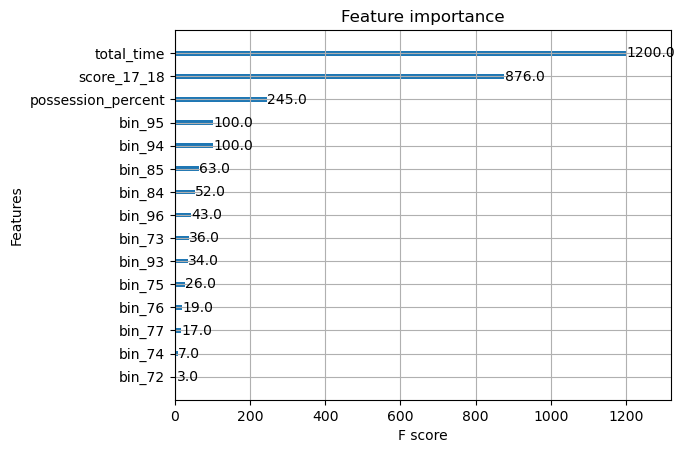

In [42]:
# Plottingg important features
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

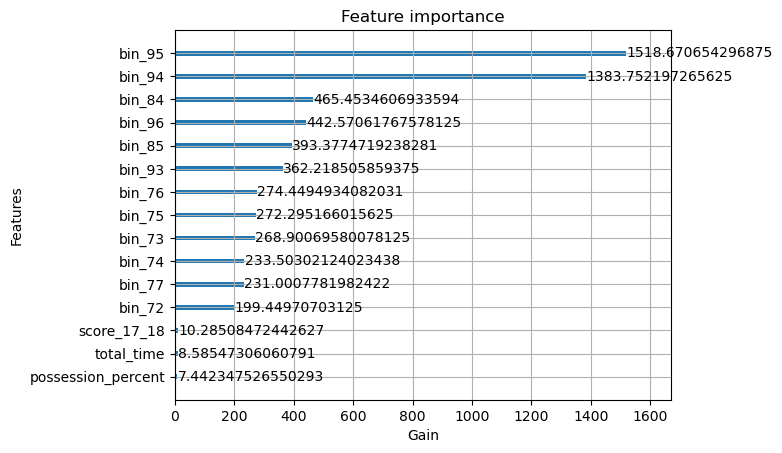

In [43]:
#We can also plot feature importance using two parameters:
# 1)gain: the 'gain' option displays the average gain of each feature when it is used in a tree

xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

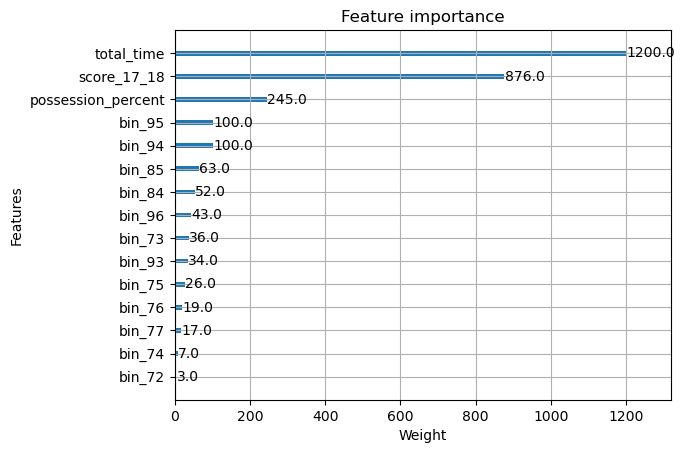

In [44]:
# 2)weight: The 'weight' option displays the number of times each feature appears in a tree

xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

# Third Model : Random Forest

In [45]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.8970380263984915
Weight of Goal Class in Training:  0.10296197360150848


In [47]:
# Define the hyperparameters to tune
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [7, 9, 12, 15, 17],
              'min_samples_split': [3, 5, 10],
              'class_weight': ['balanced', {0: weight_0, 1: weight_1}]}

In [48]:
# Define the random forest model
rf_model = RandomForestClassifier()
start_time = time.time()
# Perform nested cross-validation with grid search
grid_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_rf = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [49]:
# Fit the best model on the entire training set
grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_

end_time = time.time()

rf_training_time = end_time - start_time

In [50]:
# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print ("Model Training Time: {:.3f} seconds".format(rf_training_time))

Best parameters:  {'class_weight': 'balanced', 'max_depth': 9, 'min_samples_split': 5, 'n_estimators': 200}
Model Training Time: 1510.547 seconds


In [51]:
# Brier score on training data
rf_brs_train = brier_score_loss(y_train, best_rf_model.predict_proba(X_train)[:, 1])
# Classfication report for training data and brier score
print (classification_report(y_train, best_rf_model.predict(X_train)),rf_brs_train, end= " is the brier score on training data" )

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     22835
           1       0.33      0.60      0.43      2621

    accuracy                           0.84     25456
   macro avg       0.64      0.73      0.67     25456
weighted avg       0.89      0.84      0.85     25456
 0.18405009895256386 is the brier score on training data

In [52]:
# Evaluate the performance of the best model on the testing set
y_pred_rf = best_rf_model.predict(X_test)
# Classfication report and brier score  for testing data
rf_brs_test = brier_score_loss(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred_rf), rf_brs_test, end= " is the brier score on testing data")

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7654
           1       0.27      0.50      0.35       832

    accuracy                           0.82      8486
   macro avg       0.61      0.68      0.62      8486
weighted avg       0.87      0.82      0.84      8486
 0.19033140342896288 is the brier score on testing data

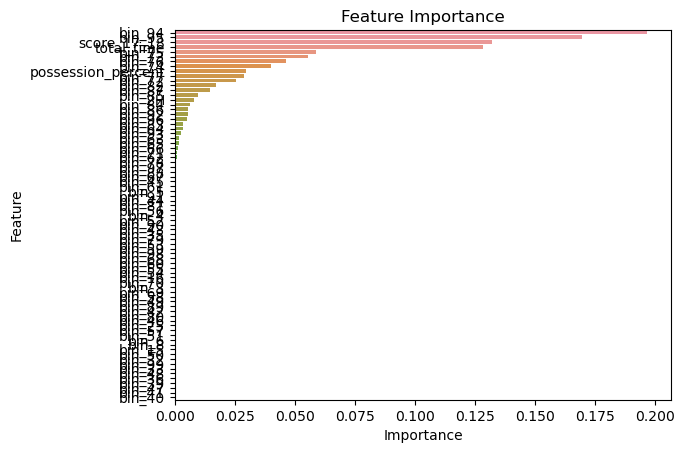

In [53]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Create barplot using seaborn
sns.barplot(x=importances[indices], y=names)

# Add x and y axis labels
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show plot
plt.show()

In [54]:
# Precision scores for the four models on training data
prec_lr_train = precision_score(y_train, best_lr_model.predict(X_train))

prec_xgb_train = precision_score(y_train, best_xgb_model.predict(X_train))

prec_rf_train = precision_score(y_train, best_rf_model.predict(X_train))

#prec_svm_train = precision_score(y_train, best_svm_model.predict(X_train))

prec_train = [prec_lr_train, prec_xgb_train, prec_rf_train]

# Precision scores for the four models on testing data
prec_lr_test = precision_score(y_test, y_pred)

prec_xgb_test = precision_score(y_test, y_pred_xgb)

prec_rf_test = precision_score(y_test, y_pred_rf)

#prec_svm_test = precision_score(y_test, y_pred_svm)

prec_test = [prec_lr_test, prec_xgb_test, prec_rf_test]

# Recall scores for the four models on training data
rec_lr_train = recall_score(y_train, best_lr_model.predict(X_train))

rec_xgb_train = recall_score(y_train, best_xgb_model.predict(X_train))

rec_rf_train = recall_score(y_train, best_rf_model.predict(X_train))

#rec_svm_train = recall_score(y_train, best_svm_model.predict(X_train))

rec_train = [rec_lr_train, rec_xgb_train, rec_rf_train]


# Calculting Recall for the four models on test data
rec_lr_test = recall_score(y_test, y_pred)

rec_xgb_test = recall_score(y_test, y_pred_xgb)

rec_rf_test = recall_score(y_test, y_pred_rf)

#rec_svm_test = recall_score(y_test, y_pred_svm)

rec_test = [rec_lr_test, rec_xgb_test, rec_rf_test]

# Accuracy scores for the four models on training data
acc_lr_train = accuracy_score(y_train, best_lr_model.predict(X_train))

acc_xgb_train = accuracy_score(y_train, best_xgb_model.predict(X_train))

acc_rf_train = accuracy_score(y_train, best_rf_model.predict(X_train))

#acc_svm_train = accuracy_score(y_train, best_svm_model.predict(X_train))

acc_train = [acc_lr_train, acc_xgb_train, acc_rf_train]

# Calculating Accuracy for the four models on test data
acc_lr_test = accuracy_score(y_test, y_pred)

acc_xgb_test = accuracy_score(y_test, y_pred_xgb)

acc_rf_test = accuracy_score(y_test, y_pred_rf)

#acc_svm_test = accuracy_score(y_test, y_pred_svm)

acc_test = [acc_lr_test, acc_xgb_test, acc_rf_test]
# Brier score for four models on training data
BRS_train = [LR_BRS_train, xgb_BRS_train, rf_brs_train]
# Brier score for four models on test data
BRS_test = [LR_BRS_test, xgb_BRS_test, rf_brs_test]


# Model training time
train_time =[lr_training_time/60, xgb_training_time/60, rf_training_time/60]

In [55]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['Logistic Regression','XG Boost','Random Forests'],
                          'Training Accuracy': acc_train, 'Training Precision': prec_train,'Training Recall':rec_train,'Training Brier': BRS_train,
                          'Testing Accuracy': acc_test, 'Testing Precision': prec_test,'Testing Recall':rec_test, 'Testing Brier': BRS_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =3).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')

,Training Accuracy,Training Precision,Training Recall,Training Brier,Testing Accuracy,Testing Precision,Testing Recall,Testing Brier,Training Time (mins)
Model Name,,,,,,,,,
Logistic Regression,0.666,0.199,0.742,0.192,0.668,0.191,0.734,0.193,6.518
XG Boost,0.796,0.264,0.550,0.202,0.796,0.245,0.518,0.204,17.471
Random Forests,0.835,0.333,0.601,0.184,0.818,0.270,0.502,0.190,25.176


In [58]:
pickle.dump(best_rf_model, open('xG_model.pkl', 'wb'))